In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
from sklearn.decomposition import PCA
import scipy

In [2]:
ph=1.5574E-4
times=[1,2,3,6,7,9,13,16,21,24,31] 
pxt=[(x) for x in list(range(3,50,1))]
neh=range(1,120)
path="C:/Workplace/C++/d2ome_v2/v2/v2/bin/Debug/"

In [3]:
all_AAs=['a', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'p','q', 'r', 's', 't', 'v', 'w', 'y']
def charcount(pepSeq):
    res={key: 0 for key in all_AAs}     
    for c in pepSeq.lower():
        if c.isalpha():
            res[c]+=1
    return res

In [4]:
def sort_pep(peptidesinfo,peptides):
    temp={p: peptidesinfo[p]["T_NEH"] for i,p in enumerate(peptides)}
    temp=dict(sorted(temp.items(), key=lambda item: item[1])) 
    return list(temp.keys()) 

In [5]:
def getPeptiedsInfo(protien,time):
    print(protien,time)

    data=pd.read_csv(path+protien+".csv")

    peptides=["_"+p+"_"+str(data.charge[index]) for index, p in enumerate(list(data.Peptied))]

    peptidesinfo=dict()
    print(len(peptides))
    data["pxt_neh"]=data["a1_t_a0_t_over_a1_0_a0_0"]


    for k in range(data.shape[0]):  

        peptidesinfo[peptides[k]]={"pxt_neh":float(data.loc[k,"a1_t_a0_t_over_a1_0_a0_0"]),
                                   "T_NEH":float(data.loc[k,"NEH"]),
                                   "Seq":data.loc[k,"Peptied"],
                                   "charcount":charcount(data.loc[k,"Peptied"])}

    visited=set()
    visited.add(peptides[0].split('_')[1])
    coefficients=[]
    peptides=sort_pep(peptidesinfo,peptides)
    for k in range(0,len(peptides)-1):
        if(peptides[k+1].split('_')[1] in visited):
            continue

        pep1=peptidesinfo[peptides[k]]
        pep2=peptidesinfo[peptides[k+1]]    
        visited.add(peptides[k].split('_')[1])

        r=pep1["pxt_neh"]/pep2["pxt_neh"]
        coefficients.append([pep1["charcount"][c]-r*pep2["charcount"][c] for c in all_AAs]) 

        
    return peptides,peptidesinfo,all_AAs,np.array(coefficients)


In [6]:
def compute_result(peptides,peptidesinfo,all_AAs,sol):
    t_neh,e_neh=[],[]
    for i in range (len(peptides)):
        pep1=peptidesinfo[peptides[i]]
        p_neh=0
        for index,c in enumerate(all_AAs): 
            p_neh+=(pep1["charcount"][c]*sol[index]) 
        t_neh.append(pep1["T_NEH"])
        e_neh.append(p_neh)

    res=pd.DataFrame([peptides,t_neh,e_neh])
    res=res.transpose()
    res.columns=["peptides","True_NEH","e_NEH"]
    res["dif"]=abs(res.True_NEH-res.e_NEH)
#     print(np.mean(res.dif),np.median(res.dif),np.std(res.dif))
    return res.sort_values(by='dif')

In [10]:
e_vals=[]
for time in times[3:]:
    print(time,"===========================================")
    # time=9
    a_val=4
    # w_val=0.08
    # proteins=["CPSM_MOUSE","FAS_MOUSE","DHB4_MOUSE","ASSY_MOUSE","ATPA_MOUSE","ATPB_MOUSE","BHMT1_MOUSE",
    #          "CLH1_MOUSE","DHE3_MOUSE","DHSO_MOUSE","ECHA_MOUSE",
    #          "G3P_MOUSE","HMCS2_MOUSE","HYES_MOUSE","MYH9_MOUSE","PYC_MOUSE","PYGL_MOUSE","SAHH_MOUSE",
    #          "SARDH_MOUSE","SBP1_MOUSE","THIM_MOUSE","TKT_MOUSE"]
    # proteins=pd.read_csv("H:/Warehouse/Data/liverpool/liver/6_23_2022_c/"+"Analyzed_Proteins_and_Their_Rates.csv").Proteins.unique()

    path="C:/Workplace/C++/d2ome_v2/v2/v2/bin/Debug/" 
    proteins=np.unique([x.replace('.csv','') for x in os.listdir(path) if ("_MOUSE.csv" in x)])

    coefficients=np.array([])
    _peptides,_peptidesinfo=[],[]
    for protine in proteins:
        try:
            peptides1,peptidesinfo1,all_AAs1,coefficients1=getPeptiedsInfo(protine,time) 
            print(protine,len(all_AAs1)==20)
            if(coefficients.shape[0]==0):
                coefficients=coefficients1
            else:
                coefficients=np.concatenate((coefficients1,coefficients), axis=0)
            _peptides.append(peptides1)
            _peptidesinfo.append(peptidesinfo1)
        except:
            continue

    # sol=list(scipy.optimize.nnls(coefficients[:,2 :],-a_val*coefficients[:,0]-w_val*coefficients[:,1])[0])
    sol=list(scipy.optimize.nnls(coefficients[:,1:],-a_val*coefficients[:,0])[0])
    # sol=list(scipy.optimize.nnls(coefficients[:,2:],-a_val*coefficients[:,0]-w_val*coefficients[:,1])[0])

    print("====>",len(sol))
    sol.insert(0,a_val) 
    # sol.insert(1,w_val) 
    print("\nValues\n","\n".join([all_AAs1[index]+"= "+str(x) for index,x in enumerate(sol)]))
    res=pd.DataFrame()
    for i in range(len(_peptides)):
        res=pd.concat([res,compute_result(_peptides[i],_peptidesinfo[i],all_AAs1,sol)])

    print("\nstats",np.mean(res.dif),np.median(res.dif),np.std(res.dif))    
    
    e_vals.append(sol)
 

6 ===========================================
__1433B_MOUSE 6
27
__1433B_MOUSE True
__1433E_MOUSE 6
6
__1433E_MOUSE True
__1433G_MOUSE 6
12
__1433G_MOUSE True
__3HAO_MOUSE 6
11
__3HAO_MOUSE True
__6PGL_MOUSE 6
19
__6PGL_MOUSE True
__AASS_MOUSE 6
31
__AASS_MOUSE True
__AATC_MOUSE 6
30
__AATC_MOUSE True
__AATM_MOUSE 6
119
__AATM_MOUSE True
__ABCD3_MOUSE 6
24
__ABCD3_MOUSE True
__ABHEB_MOUSE 6
33
__ABHEB_MOUSE True
__ACADL_MOUSE 6
56
__ACADL_MOUSE True
__ACADM_MOUSE 6
39
__ACADM_MOUSE True
__ACADS_MOUSE 6
77
__ACADS_MOUSE True
__ACADV_MOUSE 6
31
__ACADV_MOUSE True
__ACBP_MOUSE 6
14
__ACBP_MOUSE True
__ACLY_MOUSE 6
59
__ACLY_MOUSE True
__ACOC_MOUSE 6
30
__ACOC_MOUSE True
__ACON_MOUSE 6
102
__ACON_MOUSE True
__ACOX1_MOUSE 6
89
__ACOX1_MOUSE True
__ACSF2_MOUSE 6
63
__ACSF2_MOUSE True
__ACSL1_MOUSE 6
83
__ACSL1_MOUSE True
__ACSM1_MOUSE 6
62
__ACSM1_MOUSE True
__ACTB_MOUSE 6
69
__ACTB_MOUSE True
__ACTN1_MOUSE 6
29
__ACTN1_MOUSE True
__ACTN4_MOUSE 6
7
__ACTN4_MOUSE True
__ADH1_MOUSE 6
103
__ADH

49
__NDUS1_MOUSE True
__NDUS3_MOUSE 6
29
__NDUS3_MOUSE True
__NDUV1_MOUSE 6
36
__NDUV1_MOUSE True
__NIPS1_MOUSE 6
41
__NIPS1_MOUSE True
__NIT1_MOUSE 6
12
__NIT1_MOUSE True
__NIT2_MOUSE 6
24
__NIT2_MOUSE True
__NNTM_MOUSE 6
50
__NNTM_MOUSE True
__NPM_MOUSE 6
16
__NPM_MOUSE True
__NQO2_MOUSE 6
7
__NQO2_MOUSE True
__NUDT7_MOUSE 6
25
__NUDT7_MOUSE True
__OAT_MOUSE 6
26
__OAT_MOUSE True
__ODB2_MOUSE 6
4
__ODB2_MOUSE True
__ODPB_MOUSE 6
8
__ODPB_MOUSE True
__OTC_MOUSE 6
106
__OTC_MOUSE True
__PA2G4_MOUSE 6
16
__PA2G4_MOUSE True
__PABP1_MOUSE 6
20
__PABP1_MOUSE True
__PARK7_MOUSE 6
24
__PARK7_MOUSE True
__PBLD1_MOUSE 6
68
__PBLD1_MOUSE True
__PCCA_MOUSE 6
28
__PCCA_MOUSE True
__PDIA1_MOUSE 6
115
__PDIA1_MOUSE True
__PDIA3_MOUSE 6
83
__PDIA3_MOUSE True
__PDIA6_MOUSE 6
55
__PDIA6_MOUSE True
__PEBP1_MOUSE 6
27
__PEBP1_MOUSE True
__PECR_MOUSE 6
3
__PECR_MOUSE True
__PGAM1_MOUSE 6
29
__PGAM1_MOUSE True
__PGK1_MOUSE 6
60
__PGK1_MOUSE True
__PGM1_MOUSE 6
84
__PGM1_MOUSE True
__PH4H_MOUSE 6
33
__PH4H

158
__ECHA_MOUSE True
__ECHB_MOUSE 7
66
__ECHB_MOUSE True
__ECHD2_MOUSE 7
38
__ECHD2_MOUSE True
__ECHM_MOUSE 7
54
__ECHM_MOUSE True
__ECHP_MOUSE 7
18
__ECHP_MOUSE True
__ECI1_MOUSE 7
50
__ECI1_MOUSE True
__EF1A1_MOUSE 7
124
__EF1A1_MOUSE True
__EF1D_MOUSE 7
18
__EF1D_MOUSE True
__EF2_MOUSE 7
124
__EF2_MOUSE True
__EFTU_MOUSE 7
59
__EFTU_MOUSE True
__ENOA_MOUSE 7
111
__ENOA_MOUSE True
__ENPL_MOUSE 7
86
__ENPL_MOUSE True
__ENTP5_MOUSE 7
27
__ENTP5_MOUSE True
__EST1D_MOUSE 7
117
__EST1D_MOUSE True
__EST1F_MOUSE 7
33
__EST1F_MOUSE True
__EST1_MOUSE 7
36
__EST1_MOUSE True
__EST2A_MOUSE 7
47
__EST2A_MOUSE True
__EST2E_MOUSE 7
15
__EST2E_MOUSE True
__EST3A_MOUSE 7
52
__EST3A_MOUSE True
__ESTD_MOUSE 7
45
__ESTD_MOUSE True
__ETFA_MOUSE 7
109
__ETFA_MOUSE True
__ETFB_MOUSE 7
67
__ETFB_MOUSE True
__ETFD_MOUSE 7
69
__ETFD_MOUSE True
__F16P1_MOUSE 7
123
__F16P1_MOUSE True
__FAAA_MOUSE 7
100
__FAAA_MOUSE True
__FABPL_MOUSE 7
48
__FABPL_MOUSE True
__FAS_MOUSE 7
196
__FAS_MOUSE True
__FMO5_MOUSE 7
66


__VDAC1_MOUSE 7
39
__VDAC1_MOUSE True
__XYLB_MOUSE 7
19
__XYLB_MOUSE True
====> 19

Values
 a= 4
c= 0.0
d= 0.0
e= 0.0
f= 0.0
g= 0.0
h= 0.0
i= 0.0
k= 0.0
l= 0.0
m= 0.0
n= 0.0
p= 0.0
q= 0.0
r= 0.0
s= 0.0
t= 0.0
v= 0.0
w= 0.0
y= 0.0

stats 22.309333333333335 21.0 8.282798882825379
9 ===========================================
__1433B_MOUSE 9
27
__1433B_MOUSE True
__1433E_MOUSE 9
6
__1433E_MOUSE True
__1433G_MOUSE 9
12
__1433G_MOUSE True
__3HAO_MOUSE 9
11
__3HAO_MOUSE True
__6PGL_MOUSE 9
19
__6PGL_MOUSE True
__AASS_MOUSE 9
31
__AASS_MOUSE True
__AATC_MOUSE 9
30
__AATC_MOUSE True
__AATM_MOUSE 9
119
__AATM_MOUSE True
__ABCD3_MOUSE 9
24
__ABCD3_MOUSE True
__ABHEB_MOUSE 9
33
__ABHEB_MOUSE True
__ACADL_MOUSE 9
56
__ACADL_MOUSE True
__ACADM_MOUSE 9
39
__ACADM_MOUSE True
__ACADS_MOUSE 9
77
__ACADS_MOUSE True
__ACADV_MOUSE 9
31
__ACADV_MOUSE True
__ACBP_MOUSE 9
14
__ACBP_MOUSE True
__ACLY_MOUSE 9
59
__ACLY_MOUSE True
__ACOC_MOUSE 9
30
__ACOC_MOUSE True
__ACON_MOUSE 9
102
__ACON_MOUSE True
__ACOX1_

__MUTA_MOUSE 9
7
__MUTA_MOUSE True
__MYH9_MOUSE 9
28
__MYH9_MOUSE True
__NADC_MOUSE 9
39
__NADC_MOUSE True
__NCPR_MOUSE 9
36
__NCPR_MOUSE True
__NDKA_MOUSE 9
35
__NDKA_MOUSE True
__NDUAA_MOUSE 9
25
__NDUAA_MOUSE True
__NDUS1_MOUSE 9
49
__NDUS1_MOUSE True
__NDUS3_MOUSE 9
29
__NDUS3_MOUSE True
__NDUV1_MOUSE 9
36
__NDUV1_MOUSE True
__NIPS1_MOUSE 9
41
__NIPS1_MOUSE True
__NIT1_MOUSE 9
12
__NIT1_MOUSE True
__NIT2_MOUSE 9
24
__NIT2_MOUSE True
__NNTM_MOUSE 9
50
__NNTM_MOUSE True
__NPM_MOUSE 9
16
__NPM_MOUSE True
__NQO2_MOUSE 9
7
__NQO2_MOUSE True
__NUDT7_MOUSE 9
25
__NUDT7_MOUSE True
__OAT_MOUSE 9
26
__OAT_MOUSE True
__ODB2_MOUSE 9
4
__ODB2_MOUSE True
__ODPB_MOUSE 9
8
__ODPB_MOUSE True
__OTC_MOUSE 9
106
__OTC_MOUSE True
__PA2G4_MOUSE 9
16
__PA2G4_MOUSE True
__PABP1_MOUSE 9
20
__PABP1_MOUSE True
__PARK7_MOUSE 9
24
__PARK7_MOUSE True
__PBLD1_MOUSE 9
68
__PBLD1_MOUSE True
__PCCA_MOUSE 9
28
__PCCA_MOUSE True
__PDIA1_MOUSE 9
115
__PDIA1_MOUSE True
__PDIA3_MOUSE 9
83
__PDIA3_MOUSE True
__PDIA6_MOUS

__DHB5_MOUSE 13
71
__DHB5_MOUSE True
__DHE3_MOUSE 13
179
__DHE3_MOUSE True
__DHI1_MOUSE 13
46
__DHI1_MOUSE True
__DHPR_MOUSE 13
67
__DHPR_MOUSE True
__DHRS1_MOUSE 13
26
__DHRS1_MOUSE True
__DHSO_MOUSE 13
147
__DHSO_MOUSE True
__DHTK1_MOUSE 13
10
__DHTK1_MOUSE True
__DIC_MOUSE 13
14
__DIC_MOUSE True
__DLDH_MOUSE 13
64
__DLDH_MOUSE True
__DOPD_MOUSE 13
56
__DOPD_MOUSE True
__ECH1_MOUSE 13
27
__ECH1_MOUSE True
__ECHA_MOUSE 13
158
__ECHA_MOUSE True
__ECHB_MOUSE 13
66
__ECHB_MOUSE True
__ECHD2_MOUSE 13
38
__ECHD2_MOUSE True
__ECHM_MOUSE 13
54
__ECHM_MOUSE True
__ECHP_MOUSE 13
18
__ECHP_MOUSE True
__ECI1_MOUSE 13
50
__ECI1_MOUSE True
__EF1A1_MOUSE 13
124
__EF1A1_MOUSE True
__EF1D_MOUSE 13
18
__EF1D_MOUSE True
__EF2_MOUSE 13
124
__EF2_MOUSE True
__EFTU_MOUSE 13
59
__EFTU_MOUSE True
__ENOA_MOUSE 13
111
__ENOA_MOUSE True
__ENPL_MOUSE 13
86
__ENPL_MOUSE True
__ENTP5_MOUSE 13
27
__ENTP5_MOUSE True
__EST1D_MOUSE 13
117
__EST1D_MOUSE True
__EST1F_MOUSE 13
33
__EST1F_MOUSE True
__EST1_MOUSE 13
36
__

__UD2A3_MOUSE True
__UDB17_MOUSE 13
69
__UDB17_MOUSE True
__UGDH_MOUSE 13
36
__UGDH_MOUSE True
__UGPA_MOUSE 13
42
__UGPA_MOUSE True
__URIC_MOUSE 13
115
__URIC_MOUSE True
__VDAC1_MOUSE 13
39
__VDAC1_MOUSE True
__XYLB_MOUSE 13
19
__XYLB_MOUSE True
====> 19

Values
 a= 4
c= 0.0
d= 0.0
e= 0.0
f= 0.0
g= 0.0
h= 0.0
i= 0.0
k= 0.0
l= 0.0
m= 0.0
n= 0.0
p= 0.0
q= 0.0
r= 0.0
s= 0.0
t= 0.0
v= 0.0
w= 0.0
y= 0.0

stats 22.309333333333335 21.0 8.282798882825379
16 ===========================================
__1433B_MOUSE 16
27
__1433B_MOUSE True
__1433E_MOUSE 16
6
__1433E_MOUSE True
__1433G_MOUSE 16
12
__1433G_MOUSE True
__3HAO_MOUSE 16
11
__3HAO_MOUSE True
__6PGL_MOUSE 16
19
__6PGL_MOUSE True
__AASS_MOUSE 16
31
__AASS_MOUSE True
__AATC_MOUSE 16
30
__AATC_MOUSE True
__AATM_MOUSE 16
119
__AATM_MOUSE True
__ABCD3_MOUSE 16
24
__ABCD3_MOUSE True
__ABHEB_MOUSE 16
33
__ABHEB_MOUSE True
__ACADL_MOUSE 16
56
__ACADL_MOUSE True
__ACADM_MOUSE 16
39
__ACADM_MOUSE True
__ACADS_MOUSE 16
77
__ACADS_MOUSE True
__ACA

__LDHA_MOUSE True
__LGUL_MOUSE 16
21
__LGUL_MOUSE True
__LONM_MOUSE 16
18
__LONM_MOUSE True
__M2GD_MOUSE 16
107
__M2GD_MOUSE True
__MAAI_MOUSE 16
40
__MAAI_MOUSE True
__MAOX_MOUSE 16
37
__MAOX_MOUSE True
__MARC1_MOUSE 16
27
__MARC1_MOUSE True
__MCCA_MOUSE 16
7
__MCCA_MOUSE True
__MDHC_MOUSE 16
51
__MDHC_MOUSE True
__MDHM_MOUSE 16
90
__MDHM_MOUSE True
__METK1_MOUSE 16
18
__METK1_MOUSE True
__MGST1_MOUSE 16
32
__MGST1_MOUSE True
__MMSA_MOUSE 16
96
__MMSA_MOUSE True
__MTCH2_MOUSE 16
6
__MTCH2_MOUSE True
__MTP_MOUSE 16
75
__MTP_MOUSE True
__MUTA_MOUSE 16
7
__MUTA_MOUSE True
__MYH9_MOUSE 16
28
__MYH9_MOUSE True
__NADC_MOUSE 16
39
__NADC_MOUSE True
__NCPR_MOUSE 16
36
__NCPR_MOUSE True
__NDKA_MOUSE 16
35
__NDKA_MOUSE True
__NDUAA_MOUSE 16
25
__NDUAA_MOUSE True
__NDUS1_MOUSE 16
49
__NDUS1_MOUSE True
__NDUS3_MOUSE 16
29
__NDUS3_MOUSE True
__NDUV1_MOUSE 16
36
__NDUV1_MOUSE True
__NIPS1_MOUSE 16
41
__NIPS1_MOUSE True
__NIT1_MOUSE 16
12
__NIT1_MOUSE True
__NIT2_MOUSE 16
24
__NIT2_MOUSE True
__NNTM

__CMBL_MOUSE 21
21
__CMBL_MOUSE True
__CMC1_MOUSE 21
40
__CMC1_MOUSE True
__CMC2_MOUSE 21
55
__CMC2_MOUSE True
__COMT_MOUSE 21
29
__COMT_MOUSE True
__COX2_MOUSE 21
28
__COX2_MOUSE True
__COX5A_MOUSE 21
33
__COX5A_MOUSE True
__CP237_MOUSE 21
22
__CP237_MOUSE True
__CP2D9_MOUSE 21
54
__CP2D9_MOUSE True
__CP2DQ_MOUSE 21
22
__CP2DQ_MOUSE True
__CP2F2_MOUSE 21
34
__CP2F2_MOUSE True
__CP7B1_MOUSE 21
2
__CP7B1_MOUSE True
__CPSM_MOUSE 21
775
__CPSM_MOUSE True
__CPT2_MOUSE 21
52
__CPT2_MOUSE True
__CSAD_MOUSE 21
67
__CSAD_MOUSE True
__CY1_MOUSE 21
29
__CY1_MOUSE True
__CYC_MOUSE 21
19
__CYC_MOUSE True
__DCXR_MOUSE 21
5
__DCXR_MOUSE True
__DECR_MOUSE 21
35
__DECR_MOUSE True
__DEST_MOUSE 21
18
__DEST_MOUSE True
__DHB4_MOUSE 21
45
__DHB4_MOUSE True
__DHB5_MOUSE 21
71
__DHB5_MOUSE True
__DHE3_MOUSE 21
179
__DHE3_MOUSE True
__DHI1_MOUSE 21
46
__DHI1_MOUSE True
__DHPR_MOUSE 21
67
__DHPR_MOUSE True
__DHRS1_MOUSE 21
26
__DHRS1_MOUSE True
__DHSO_MOUSE 21
147
__DHSO_MOUSE True
__DHTK1_MOUSE 21
10
__DHTK1

__ST1A1_MOUSE True
__STA10_MOUSE 21
37
__STA10_MOUSE True
__SUCA_MOUSE 21
36
__SUCA_MOUSE True
__SUCB1_MOUSE 21
40
__SUCB1_MOUSE True
__SUCB2_MOUSE 21
39
__SUCB2_MOUSE True
__SUOX_MOUSE 21
19
__SUOX_MOUSE True
__SURF4_MOUSE 21
11
__SURF4_MOUSE True
__SYEP_MOUSE 21
14
__SYEP_MOUSE True
__TBB2A_MOUSE 21
31
__TBB2A_MOUSE True
__TBB4B_MOUSE 21
9
__TBB4B_MOUSE True
__TCPG_MOUSE 21
12
__TCPG_MOUSE True
__TCPH_MOUSE 21
19
__TCPH_MOUSE True
__TCPZ_MOUSE 21
8
__TCPZ_MOUSE True
__TERA_MOUSE 21
46
__TERA_MOUSE True
__THIC_MOUSE 21
36
__THIC_MOUSE True
__THIKA_MOUSE 21
74
__THIKA_MOUSE True
__THIKB_MOUSE 21
15
__THIKB_MOUSE True
__THIL_MOUSE 21
67
__THIL_MOUSE True
__THIM_MOUSE 21
175
__THIM_MOUSE True
__THTR_MOUSE 21
66
__THTR_MOUSE True
__TKFC_MOUSE 21
57
__TKFC_MOUSE True
__TKT_MOUSE 21
108
__TKT_MOUSE True
__TPIS_MOUSE 21
57
__TPIS_MOUSE True
__TTC38_MOUSE 21
29
__TTC38_MOUSE True
__UBA1_MOUSE 21
4
__UBA1_MOUSE True
__UD11_MOUSE 21
61
__UD11_MOUSE True
__UD2A3_MOUSE 21
59
__UD2A3_MOUSE True
__

__IDHC_MOUSE True
__IDHP_MOUSE 24
37
__IDHP_MOUSE True
__IF4A1_MOUSE 24
25
__IF4A1_MOUSE True
__INMT_MOUSE 24
59
__INMT_MOUSE True
__IPYR_MOUSE 24
34
__IPYR_MOUSE True
__IQGA2_MOUSE 24
53
__IQGA2_MOUSE True
__ISC2A_MOUSE 24
37
__ISC2A_MOUSE True
__ISOC1_MOUSE 24
27
__ISOC1_MOUSE True
__IVD_MOUSE 24
33
__IVD_MOUSE True
__K1C18_MOUSE 24
106
__K1C18_MOUSE True
__K2C8_MOUSE 24
113
__K2C8_MOUSE True
__KAD2_MOUSE 24
42
__KAD2_MOUSE True
__KAD3_MOUSE 24
11
__KAD3_MOUSE True
__KBL_MOUSE 24
21
__KBL_MOUSE True
__KHK_MOUSE 24
26
__KHK_MOUSE True
__KMO_MOUSE 24
26
__KMO_MOUSE True
__KPYR_MOUSE 24
15
__KPYR_MOUSE True
__LDHA_MOUSE 24
62
__LDHA_MOUSE True
__LGUL_MOUSE 24
21
__LGUL_MOUSE True
__LONM_MOUSE 24
18
__LONM_MOUSE True
__M2GD_MOUSE 24
107
__M2GD_MOUSE True
__MAAI_MOUSE 24
40
__MAAI_MOUSE True
__MAOX_MOUSE 24
37
__MAOX_MOUSE True
__MARC1_MOUSE 24
27
__MARC1_MOUSE True
__MCCA_MOUSE 24
7
__MCCA_MOUSE True
__MDHC_MOUSE 24
51
__MDHC_MOUSE True
__MDHM_MOUSE 24
90
__MDHM_MOUSE True
__METK1_MOUSE 

__CMBL_MOUSE True
__CMC1_MOUSE 31
40
__CMC1_MOUSE True
__CMC2_MOUSE 31
55
__CMC2_MOUSE True
__COMT_MOUSE 31
29
__COMT_MOUSE True
__COX2_MOUSE 31
28
__COX2_MOUSE True
__COX5A_MOUSE 31
33
__COX5A_MOUSE True
__CP237_MOUSE 31
22
__CP237_MOUSE True
__CP2D9_MOUSE 31
54
__CP2D9_MOUSE True
__CP2DQ_MOUSE 31
22
__CP2DQ_MOUSE True
__CP2F2_MOUSE 31
34
__CP2F2_MOUSE True
__CP7B1_MOUSE 31
2
__CP7B1_MOUSE True
__CPSM_MOUSE 31
775
__CPSM_MOUSE True
__CPT2_MOUSE 31
52
__CPT2_MOUSE True
__CSAD_MOUSE 31
67
__CSAD_MOUSE True
__CY1_MOUSE 31
29
__CY1_MOUSE True
__CYC_MOUSE 31
19
__CYC_MOUSE True
__DCXR_MOUSE 31
5
__DCXR_MOUSE True
__DECR_MOUSE 31
35
__DECR_MOUSE True
__DEST_MOUSE 31
18
__DEST_MOUSE True
__DHB4_MOUSE 31
45
__DHB4_MOUSE True
__DHB5_MOUSE 31
71
__DHB5_MOUSE True
__DHE3_MOUSE 31
179
__DHE3_MOUSE True
__DHI1_MOUSE 31
46
__DHI1_MOUSE True
__DHPR_MOUSE 31
67
__DHPR_MOUSE True
__DHRS1_MOUSE 31
26
__DHRS1_MOUSE True
__DHSO_MOUSE 31
147
__DHSO_MOUSE True
__DHTK1_MOUSE 31
10
__DHTK1_MOUSE True
__DIC_M

__THIKA_MOUSE True
__THIKB_MOUSE 31
15
__THIKB_MOUSE True
__THIL_MOUSE 31
67
__THIL_MOUSE True
__THIM_MOUSE 31
175
__THIM_MOUSE True
__THTR_MOUSE 31
66
__THTR_MOUSE True
__TKFC_MOUSE 31
57
__TKFC_MOUSE True
__TKT_MOUSE 31
108
__TKT_MOUSE True
__TPIS_MOUSE 31
57
__TPIS_MOUSE True
__TTC38_MOUSE 31
29
__TTC38_MOUSE True
__UBA1_MOUSE 31
4
__UBA1_MOUSE True
__UD11_MOUSE 31
61
__UD11_MOUSE True
__UD2A3_MOUSE 31
59
__UD2A3_MOUSE True
__UDB17_MOUSE 31
69
__UDB17_MOUSE True
__UGDH_MOUSE 31
36
__UGDH_MOUSE True
__UGPA_MOUSE 31
42
__UGPA_MOUSE True
__URIC_MOUSE 31
115
__URIC_MOUSE True
__VDAC1_MOUSE 31
39
__VDAC1_MOUSE True
__XYLB_MOUSE 31
19
__XYLB_MOUSE True
====> 19

Values
 a= 4
c= 0.0
d= 0.0
e= 0.0
f= 0.0
g= 0.0
h= 0.0
i= 0.0
k= 0.0
l= 0.0
m= 0.0
n= 0.0
p= 0.0
q= 0.0
r= 0.0
s= 0.0
t= 0.0
v= 0.0
w= 0.0
y= 0.0

stats 22.309333333333335 21.0 8.282798882825379


In [11]:
len(_peptides)#,_peptidesinfo[i]

302

In [12]:
coefficients

array([[ 0.37203329, -0.62796671, -0.31398336, ..., -0.62796671,
        -0.31398336,  0.        ],
       [-0.25736216, -0.62868108, -1.25736216, ...,  1.37131892,
         0.        ,  0.37131892],
       [ 1.24366297,  1.        ,  0.48732593, ...,  0.24366297,
        -0.75633703,  1.        ],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -1.84865545,
         0.        , -1.42432773],
       [-0.68895488,  0.        ,  1.        , ..., -0.68895488,
         0.        , -0.68895488],
       [-1.8923726 ,  0.        ,  0.        , ...,  1.        ,
         0.        , -0.4461863 ]])

In [13]:
evals2=np.array(e_vals)
trueval=[4.0,1.62,1.89,3.95,0.32,2.06,2.88,1.0,0.6,0.54,1.12,1.89,2.59,3.95,3.43,2.61,0.2,0.56,0.08,0.42]

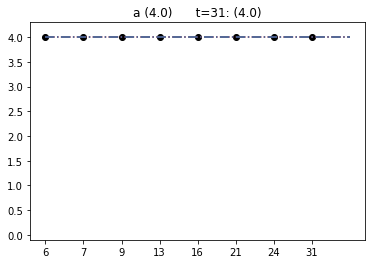

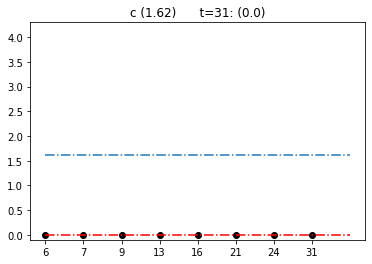

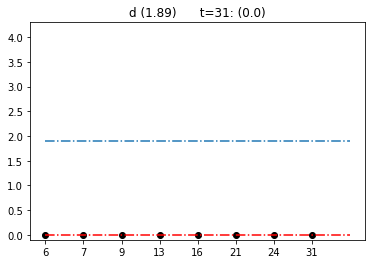

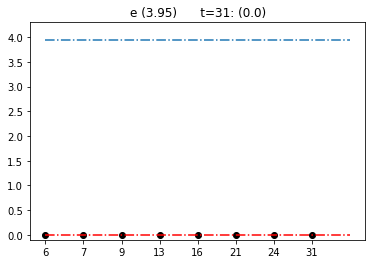

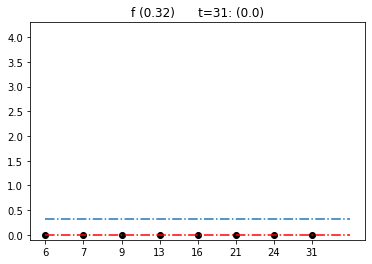

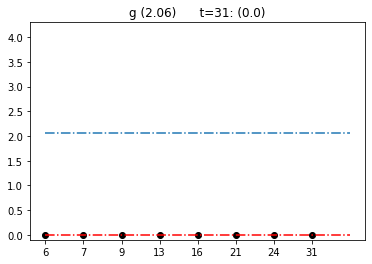

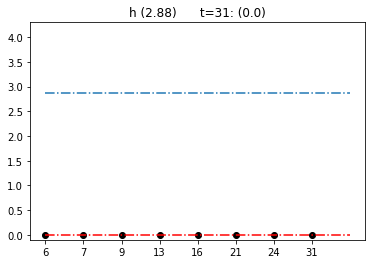

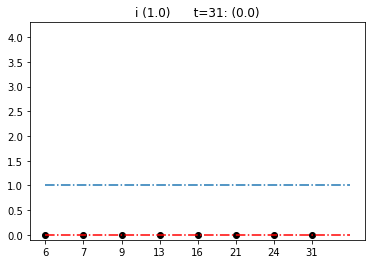

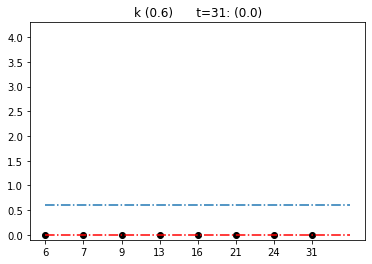

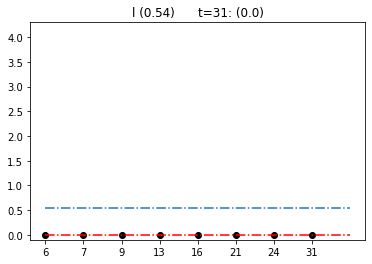

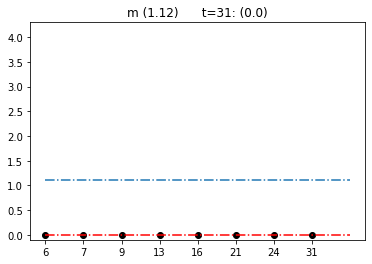

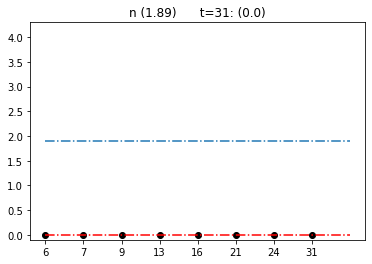

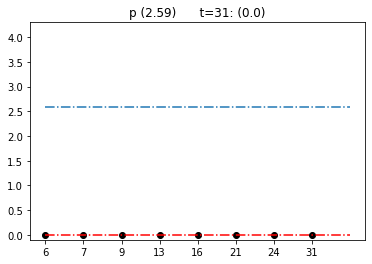

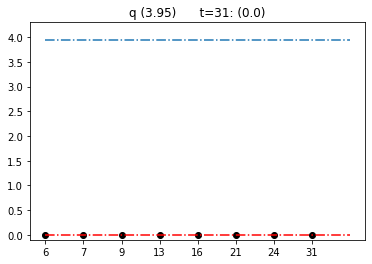

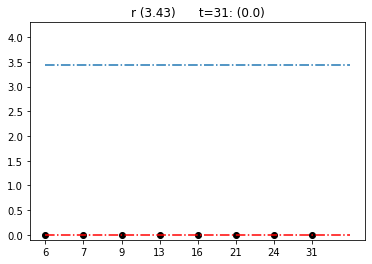

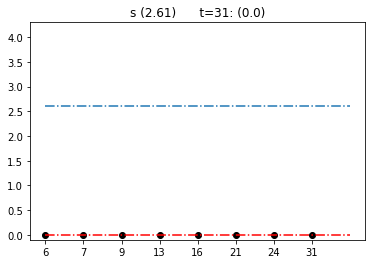

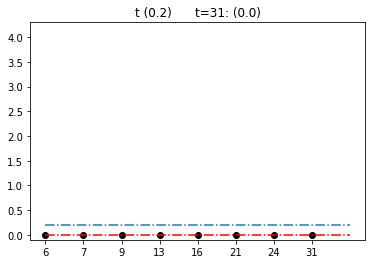

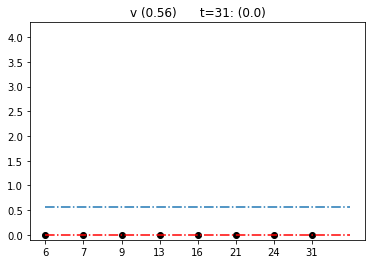

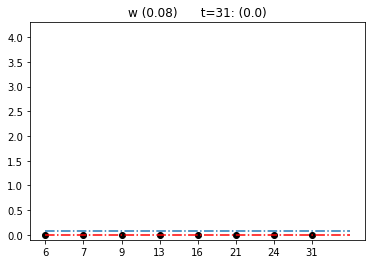

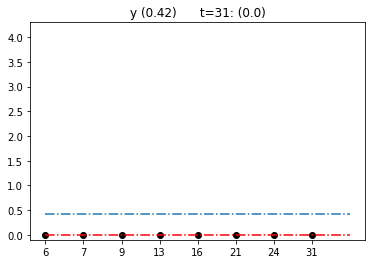

In [14]:
for i in range(len(all_AAs1)):
    plt.scatter(range(8),evals2[:,i],c='k')
    plt.xticks(np.arange(8), times[3:])
    plt.title(all_AAs1[i]+f" ({trueval[i]})"+f"      t=31: ({evals2[:,i][-1]})")
    plt.ylim([-0.1,4.3])
    plt.hlines(y=np.median(evals2[:,i]),xmin=0,xmax=8,linestyle="-.",color='r')
    plt.hlines(y=trueval[i],xmin=0,xmax=8,linestyle="-.")
    plt.show()
    

In [15]:
print("\nValues\n","\n".join([all_AAs1[index]+"= "+str(x) for index,x in enumerate(sol)]))


Values
 a= 4
c= 0.0
d= 0.0
e= 0.0
f= 0.0
g= 0.0
h= 0.0
i= 0.0
k= 0.0
l= 0.0
m= 0.0
n= 0.0
p= 0.0
q= 0.0
r= 0.0
s= 0.0
t= 0.0
v= 0.0
w= 0.0
y= 0.0


In [16]:
print("proteins",len(proteins),"peptides",res.shape[0])

proteins 339 peptides 2250


In [17]:
res=res.sort_values(by='dif')
res.head(20)

,peptides,True_NEH,e_NEH,dif
0,_TTAAAVILK_2,15.0,12.0,3.0
1,_YGLAAAVFTK_2,16.0,12.0,4.0
0,_TALYVANLIK_2,13.0,8.0,5.0
0,_FPLFTAVYK_2,9.0,4.0,5.0
0,_ADLIAYLK_2,13.0,8.0,5.0
0,_LVEIAAK_2,14.0,8.0,6.0
1,_DYYFALAH_2,14.0,8.0,6.0
0,_ATFDAISK_2,14.0,8.0,6.0
0,_FAELTLK_2,10.0,4.0,6.0
0,_LAEVALAYAK_2,22.0,16.0,6.0


In [18]:
res.tail(20)

,peptides,True_NEH,e_NEH,dif
4,_HLEGLSEEAIMELNLPTGIPIVYELDK_3,51.0,4.0,47.0
10,_RPLIDQVVQTALSETQDPEEVSVTVK_3,51.0,4.0,47.0
2,_LQIAAcSNQDPLQGTTGLIPLLGIDVWEHAY_3,59.0,12.0,47.0
16,_ASGKPVAATMcIGPEGDLHGVPPGEcAVR_4,63.0,16.0,47.0
7,_HVNGQDQIVPGLYAcGEAAcASVHGANR_4,67.0,20.0,47.0
11,_SKPIQEVLQEMTDGGVDFSFEVIGR_3,47.0,0.0,47.0
6,_STGGVGGDVLIDIGSGPTIYQLLSAcEVFR_3,51.0,4.0,47.0
2,_NMGGPYGGGNYGPGGSGGSGGYGGR_3,48.0,0.0,48.0
8,_cPEALFQPSFLGMEScGIHETTFNSIMK_3,52.0,4.0,48.0
5,_ASFANEDGQVSPGSLLLAGAIAGMPAASLVTPADVIK_3,80.0,32.0,48.0


In [19]:
temp=pd.DataFrame(coefficients)
temp.columns=all_AAs1
temp 

,a,c,d,e,f,g,h,i,k,l,m,n,p,q,r,s,t,v,w,y
0,0.372033,-0.627967,-0.313983,0.372033,0.000000,0.000000,-0.313983,1.000000,-0.313983,1.372033,0.0,0.000000,0.686017,0.686017,1.000000,0.686017,1.000000,-0.627967,-0.313983,0.000000
1,-0.257362,-0.628681,-1.257362,0.000000,0.371319,1.000000,0.000000,0.000000,0.371319,0.000000,0.0,1.000000,-0.628681,0.371319,0.000000,0.371319,1.000000,1.371319,0.000000,0.371319
2,1.243663,1.000000,0.487326,-1.512674,1.000000,-0.756337,0.000000,-0.756337,1.000000,-1.512674,0.0,-1.512674,1.000000,0.243663,-0.756337,1.000000,-3.025348,0.243663,-0.756337,1.000000
3,-0.216668,0.000000,-0.433335,-0.433335,0.000000,-0.216668,0.000000,-0.216668,0.000000,-0.433335,0.0,-0.433335,0.000000,-0.216668,-0.216668,0.000000,-0.866671,-0.216668,-0.216668,0.000000
4,0.000000,0.000000,0.000000,-0.101058,2.000000,0.898942,0.000000,0.000000,-0.101058,1.000000,0.0,0.000000,-1.101058,-0.101058,0.000000,-1.202117,2.000000,-1.101058,0.000000,-1.101058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,0.631148,0.000000,1.000000,1.000000,1.000000,-6.844260,0.000000,1.000000,1.000000,-0.737704,0.0,0.000000,1.000000,-1.368852,-1.368852,-0.368852,-0.368852,-1.737704,0.000000,0.000000
1632,-0.784113,1.000000,1.000000,-0.784113,-0.784113,0.215887,0.000000,-0.568227,-0.784113,3.000000,0.0,-0.784113,0.000000,0.215887,1.000000,0.215887,-1.568227,0.215887,0.000000,0.000000
1633,1.000000,0.000000,0.000000,0.287836,1.000000,-1.136492,0.000000,2.000000,1.000000,-2.848655,0.0,1.000000,-0.712164,1.000000,-0.712164,-1.136492,2.000000,-1.848655,0.000000,-1.424328
1634,-0.688955,0.000000,1.000000,-1.377910,0.000000,-0.688955,0.000000,1.000000,-0.688955,2.311045,1.0,-0.688955,0.000000,1.000000,1.000000,-0.377910,1.000000,-0.688955,0.000000,-0.688955


In [20]:
# for c in range( len(coefficients)):
#     print(np.dot(coefficients[c],sol))

In [21]:
ypred=[np.dot(coefficients[c],sol) for c in range(coefficients.shape[0])]
sigma=sum([ (0-x)**2 for x in ypred])/(len(ypred)-20-1)
cov=((sigma**2)*np.linalg.inv(np.matmul(coefficients.transpose(),coefficients)))
var=[cov[x][x] for x in range(20)]
ci_ub=[coefficients[i]+1.96*var[i] for i in range(20)]
ci_lb=[coefficients[i]-1.96*var[i] for i in range(20)]
ci=[1.96*var[i] for i in range(20)]

temp=pd.DataFrame()
temp["AA"]=all_AAs1
temp["E_value"]=sol
temp["T_value"]=trueval
temp["var"]=var
temp["CI"]=ci
temp.sort_values(by="var")

,AA,E_value,T_value,var,CI
0,a,4.0,4.00,2.400659e+08,4.705291e+08
9,l,0.0,0.54,2.841376e+08,5.569098e+08
5,g,0.0,2.06,3.937204e+08,7.716920e+08
4,f,0.0,0.32,4.761390e+08,9.332325e+08
12,p,0.0,2.59,5.514927e+08,1.080926e+09
17,v,0.0,0.56,5.543104e+08,1.086448e+09
3,e,0.0,3.95,6.721058e+08,1.317327e+09
16,t,0.0,0.20,7.488524e+08,1.467751e+09
15,s,0.0,2.61,7.932462e+08,1.554763e+09
13,q,0.0,3.95,1.001638e+09,1.963210e+09


In [ ]:
ypred=[np.dot(coefficients[c],sol) for c in range(coefficients.shape[0])]
sigma=sum([ (0-x)**2 for x in ypred])/(len(ypred)-20-1)
cov=((sigma**2)*np.linalg.inv(np.matmul(coefficients[:,1:].transpose(),coefficients[:,1:])))
var=[cov[x][x] for x in range(19)]
ci_ub=[coefficients[i+1]+1.96*var[i] for i in range(19)]
ci_lb=[coefficients[i+1]-1.96*var[i] for i in range(19)]
ci=[1.96*var[i] for i in range(19)]

temp=pd.DataFrame()
temp["AA"]=all_AAs1[1:]
temp["E_value"]=sol[1:]
temp["T_value"]=trueval[1:]
temp["var"]=var
temp["CI"]=ci
temp.sort_values(by="var")